# Introduction to PyTorch

- [PyTorch](http://pytorch.org/) it's a framework for developing and training neural networks. 
- It's very similar to numpy, but here, `array` is called `tensors`
- `tensors` make the communication between CPU and GPU much easier than `arrays`
- also, pytorch has usefull functions to calculate gradients (which is great for backpropagation tasks) and build neural networks
- compared with tensorflow and other frameworks, pytorch is better to work with python / numpy / scipy

Simple machine learning models (e.g. like perceptron, and linear and logistic regression) must solve linear equations like:

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

representing with vectors:

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix}
$$


## Tensors

- Linear algebra with `tensors`, matrix genaralization, and other math areas are  exactly what machine algorithms do..
   - vector is a 1D tensor
   - matrix is a 2D tensor
   - a 3D array is a 3D tensor (e.g. RBG images)


In [3]:
import torch

In [4]:
def activation_function_sigmoid(x):
    """ Defining the activation function - Sigmoid
    
        Args:
        ---------
        x: torch.Tensor
        return: Sigmoid f(x)
    """
    return 1/(1+torch.exp(-x))

In [5]:
### GENERATING RANDOM DATA
torch.manual_seed(7) # Setting the seed for replicable results

# creating a tensor with 1 line (because we have only 1 sample) and 5 columns (5 features per sample), 
features = torch.randn((1, 5))     #   torch.randn ---> normal distribution with mean=0 and variance=1

# generating wandom weights for the model: randn_like 
weights = torch.randn_like(features)   # it generates other tensors with the same characteristics of "features"

# BIAS term - it's a tensor with only 1 line and 1 column
bias = torch.randn((1, 1))

In [6]:
print('features:', features)
print('weights: ', weights)
print('bias:    ', bias)

features: tensor([[-0.1468,  0.7861,  0.9468, -1.1143,  1.6908]])
weights:  tensor([[-0.8948, -0.3556,  1.2324,  0.1382, -1.6822]])
bias:     tensor([[0.3177]])


* Just like `arrays`, `tensors` can be added, subtracted, multiplied, etc.
* the advantage here, it that we can use the GPU 

## Example: computing the output of a neuron model

In [7]:
### HOW TO PREDICT THE OUTPUT OF THE NEURON:

# Just like numpy, we can use torch.sum(), assim como o métodos .sum() nos tensores.

# torch.sum(w * f + b) which is the 1st degree equation
y1 = activation_function_sigmoid(torch.sum(features * weights) + bias)
print('option 1: ', y1)

# .sum()
y2 = activation_function_sigmoid((features * weights).sum() + bias)
print('option 2: ', y2)

# or we can multiply the matrixes (+effective, especially with GPUs) using torch.mm() or torch.matmul()
#  torch.mm()
y3 = activation_function_sigmoid(torch.mm(features, weights.view(5,1)) + bias)
print('option 3: ', y3)

option 1:  tensor([[0.1595]])
option 2:  tensor([[0.1595]])
option 3:  tensor([[0.1595]])


- As we can see, we have here 3 ways of getting to the same result!
- Note that in 3rd option, we had to reshape our tensor weights by calling 'view(5,1)'
- The error would be `RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 1x5)`
- To reshape our vector, we can use:

    1) `tensor.shape`

    2) `tensor.reshape()`

    3) `tensor.resize_()`

    4) `tensor.view()`

In [8]:
#torch.mm(features, weights)   # ERROR: just to show how it  would be if we didnt reshape the tensor weights

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 1x5)

## Converting between Numpy **and** Pytorch

In [10]:
import numpy as np
# generating a random numpy array of 4 lines and 3 columns
a = np.random.rand(4,3)
a

array([[0.47506785, 0.62539407, 0.571893  ],
       [0.947377  , 0.86909497, 0.53773338],
       [0.09605942, 0.24226119, 0.11633336],
       [0.89349753, 0.39697777, 0.89883288]])

In [11]:
# Converting to tensor
b = torch.from_numpy(a)
b

tensor([[0.4751, 0.6254, 0.5719],
        [0.9474, 0.8691, 0.5377],
        [0.0961, 0.2423, 0.1163],
        [0.8935, 0.3970, 0.8988]], dtype=torch.float64)

In [12]:
# converting back to numpy
b.numpy()

array([[0.47506785, 0.62539407, 0.571893  ],
       [0.947377  , 0.86909497, 0.53773338],
       [0.09605942, 0.24226119, 0.11633336],
       [0.89349753, 0.39697777, 0.89883288]])

In [13]:
# if we change an object 'inplace', we change both objects
# so, if we multiply 'b' by 2, in-place (passing the inplace version of mul: 'mul_')
b.mul_(2)
print(b)
print(a)

tensor([[0.9501, 1.2508, 1.1438],
        [1.8948, 1.7382, 1.0755],
        [0.1921, 0.4845, 0.2327],
        [1.7870, 0.7940, 1.7977]], dtype=torch.float64)
[[0.95013569 1.25078814 1.143786  ]
 [1.894754   1.73818994 1.07546675]
 [0.19211885 0.48452238 0.23266671]
 [1.78699506 0.79395554 1.79766577]]


## Linear Regression with PyTorch


In [14]:
import torch
from torch.autograd import Variable   # variable that will be altered by gradient descent
from torch.nn import functional as F

In [15]:
# checking if the PyTorch version is using GPU
print('PyTorch version: ', torch.__version__)
print('Using GPU: ', torch.cuda.is_available())

if torch.cuda.is_available():    
    print('GPU: ',torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch version:  1.9.0
Using GPU:  True
GPU:  GeForce GTX 1660 Ti with Max-Q Design


- At this moment, I'm not using a GPU so the message was `False`
### Generating random samples

In [16]:
x_data = Variable(torch.Tensor([[10.0], [9.0], [3.0], [2.0]]))
y_data = Variable(torch.Tensor([[90.0], [80.0], [50.0], [30.0]]))
x_data

tensor([[10.],
        [ 9.],
        [ 3.],
        [ 2.]])

### Configuring the class of our Linear Regression model
- which will inherit from `torch.nn.Module`
- Defining `__init__`: which inherit from the super and we add a linear layer `self.linear` with 1 feature and 1 output
- Weights and bias are inside the layer, that why we don't define them again
- Method `forward`: pass the instructions of the model from the input to the output
- Linear function is very simple, so we receive $x$ and predict a value ($\hat{y}$) for $y$.

In [69]:
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1)  #first is the number of features, second is number of output
    
    # the define our forward method, we must pass x to predict y
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

# instantiating the model    
model = LinearRegression()

### Loss function (Criterion)

- After executing the method `forward`, the loss function is used to compute how far if $\hat{y}$ from $y$
- With this loss function we can make some adjustments in the weights to get that difference closest to 0
- We will use _Mean Square Error (MSE)_, commonly used at regression tasks.

### Optimizer _Stochastic Gradient Descent (SGD)_
- This optimizer will be used to update the weights of the model
- the function `model.parameters()` tells our optimizer which weights will be updated
- `lr` tells us what's going to be the learning rate


In [70]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Trainning the model
after the forward step, we modify the weights by backpropagation

### Backpropagation
1) Random weights
2) Epochs: partial 
   - partial derivative of each weight for each layer
   - forward step calculates the function of each neuron (a)
   - backward
   - each neuron loss is calculated
   - accumulate each partial derivative
   - Mean Gradient
   - Use Gradient Descent to update the weights
   - evaluate the loss function **J**

In [71]:
#difining for how many epochs we'll pass to the model
epochs = 20

for epoch in range(epochs):
    model.train()
       # Zero the gradients at each epoch (using backpropagation)
    optimizer.zero_grad()
       # Forward pass
    y_pred = model(x_data)
       # Computa o erro
    loss = criterion(y_pred, y_data)
       # propagate error to the previous layers
    loss.backward()
       # Atualiza os pesos
    optimizer.step()

### Making predictions

In [72]:
new_x = Variable(torch.Tensor([[4.0]]))
y_pred = model(new_x)
print("estimated value: ", float(y_pred.data[0][0]))

estimated value:  39.59628677368164


## Logistic Regression
- Using Fashion MNIST data 
- pixels : **28 x 28**
- 10 classes of each type (e.g.: 10 pants, 10 shoes, 10 shirts,...)

![MNIST](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/05/04/ImagesSageMaker3.png)

## Transforms
- PyTorch can't process an image pixel directly 
- So, the images needs to be converted to tensors 
- Using torchvision (specialized library for vision and image-related tasks) we can call `transform`
- Transform provides APIs for:
   - converting pixels into tensors
   - normalizing standard scaling
   - flip data (horizontal, vertical)
   - image from RGB ---> b/w
   - and so on...

In [73]:
import torch
from torch.autograd import Variable

# transforms: we can use this to make some transformations in the original dataset
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [74]:
### Downloading datasets
# 60.000 train samples
# 10.000 test samples

train_dataset = dsets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())

### Creating data loaders 

In [75]:
batch_size = 100    # divide our 60.000 samples in 600 batches x 100 batch_size

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input_dim = 784   # pixels 28 x 28 = 784 
output_dim = 10   # number of classes

### Creating the Logistic Regression's class
- inherit from `torch.nn.Module`
- `__init__` method inherit from super as well
- creating the linear parameter with input and output dimensions
- method `forward` that receives x and return the output

In [76]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

### Defining hiperparameters

In [80]:
n_iters = 9000   #iterations at each batch
# defining the epochs: in this case, 9000 / (60.000 / 100)
epochs = n_iters / (len(train_dataset) / batch_size)
#input_dim = 784
#output_dim = 10
lr_rate = 0.001  # learning rate

### Loss function
- Cross-Entropy (CE), which is close to Maximum Likelihood Estimation (MLE)

### update the weights
- using the optimizer _Stochastic Gradient Descent (SGD)_

In [78]:
model = LogisticRegression(input_dim, output_dim)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

### Trainning the model

In [81]:
iter = 0
for epoch in range(int(epochs)):
             # getting the batches (from train_loader)
    for i, (images, labels) in enumerate(train_loader):
           # creating and resizing the image from the batch
        images = Variable(images.view(-1, 28 * 28))        # reshaping 1 vector of 784 dims
           # creating the labels also from batch
        labels = Variable(labels)                 # Variable: will be altered by gradient descent
           # must zero gradients for each epoch
        optimizer.zero_grad()
           # forward pass to compute each output
        outputs = model(images)
           # loss function: cross entropy
        loss = criterion(outputs, labels)
           # propagating the error by backward step
        loss.backward()
        optimizer.step()

        iter+=1
           # each time that iter has no remains when divided by 500, we get into this if
           ## and print the iteration time, loss and accuracy comparing to test_loader
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                        # .max() gets the class with highest probability (between 10)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.8174324631690979. Accuracy: 70.4000015258789.
Iteration: 1000. Loss: 0.8669449687004089. Accuracy: 71.18000030517578.
Iteration: 1500. Loss: 0.9107009172439575. Accuracy: 72.08000183105469.
Iteration: 2000. Loss: 0.7608199119567871. Accuracy: 72.41000366210938.
Iteration: 2500. Loss: 0.8078849911689758. Accuracy: 73.33999633789062.
Iteration: 3000. Loss: 0.7184672355651855. Accuracy: 73.72000122070312.
Iteration: 3500. Loss: 0.8137944936752319. Accuracy: 74.12000274658203.
Iteration: 4000. Loss: 0.7207720875740051. Accuracy: 74.58999633789062.
Iteration: 4500. Loss: 0.7779765129089355. Accuracy: 74.91000366210938.
Iteration: 5000. Loss: 0.7306163907051086. Accuracy: 75.25.
Iteration: 5500. Loss: 0.7243243455886841. Accuracy: 75.38999938964844.
Iteration: 6000. Loss: 0.6138189435005188. Accuracy: 75.63999938964844.
Iteration: 6500. Loss: 0.7096003890037537. Accuracy: 75.98999786376953.
Iteration: 7000. Loss: 0.7651185393333435. Accuracy: 76.16999816894531.
Iterat

## Plotting random images from the dataset
- I tried using the method imshow from `helper` lib, but didn't worked
- So, the [solution](https://stackoverflow.com/questions/53570181/error-in-importing-libraries-of-helper-though-helper-is-installed) was to define a function to show the Tensor images
- also, when calling the second iterator i ran into an error.
- At [pytorch forum](https://discuss.pytorch.org/t/typeerror-int-object-is-not-callable-when-using-second-iterator/30312) was the solution:
   - replace `iter(object)` for `object.__iter__()`


In [43]:
len(train_loader)

600

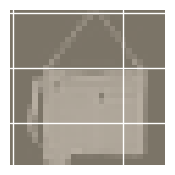

In [82]:
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(2,3))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return plt.show()

image, label = next(train_loader.__iter__())
ax = imshow(image[0,:])

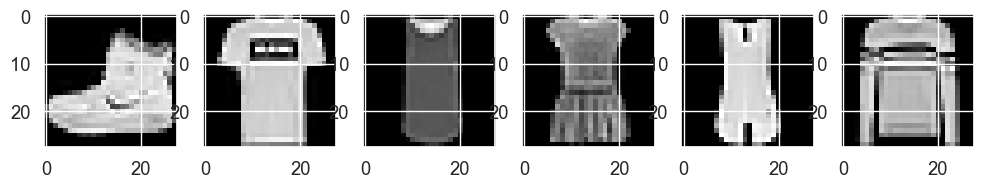

In [83]:
# another way of showing images
num_imagens = 6
fig, axs = plt.subplots(1, num_imagens, figsize=(12, 4))
for i in range(num_imagens):
    axs[i].imshow(train_dataset[i][0].reshape(28, 28), cmap=plt.get_cmap("gray"))
plt.show()

## Estimating sample labels from test samples
- compute the accuracy and generate a confusion matrix

In [84]:
predicted_list = []
estimated_list = []

for images, labels in test_dataset:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    # class 'torch.Tensor'
    predicted_list.append(predicted.item())
    estimated_list.append(labels)

In [85]:
import pandas as pd

estimations = pd.DataFrame(data={'predicted':predicted_list, 'estimated':estimated_list})
estimations.head()

,predicted,estimated
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6


## Calculating the Accuracy

In [86]:
## accuracy will be the correct predictions divided by all predictions
accuracy = (estimations['predicted'] == estimations['estimated']).sum()/len(estimations)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 77.04%


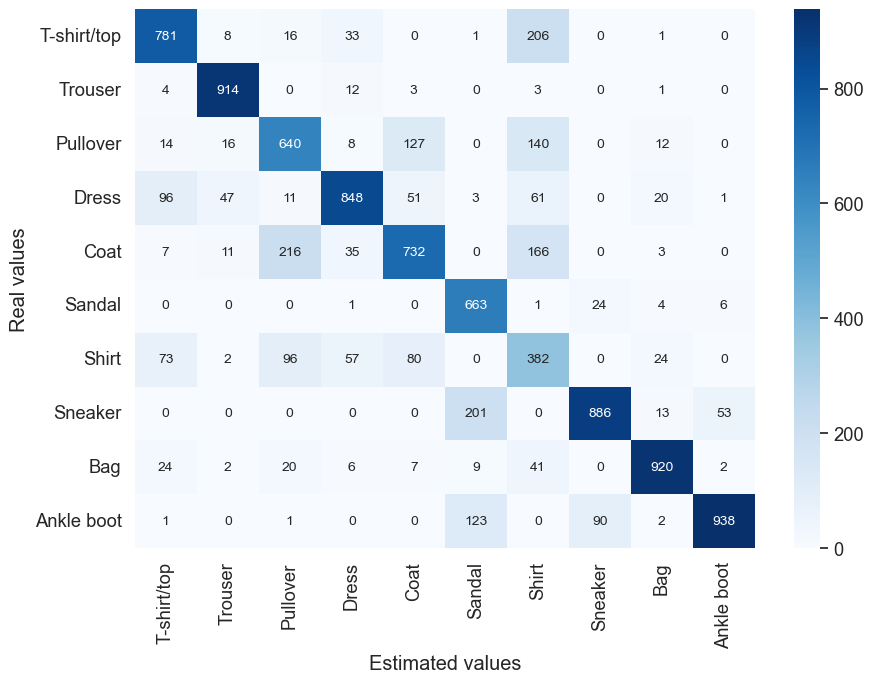

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

clothes_labels = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
                  5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

# instantiatin the confusion matrix
cm = confusion_matrix(predicted_list, estimated_list)

df_cm = pd.DataFrame(cm, columns=clothes_labels.values(), index=clothes_labels.values())
df_cm.index.name = "Real values"
df_cm.columns.name = "Estimated values"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()

# Now, using the dataset Kuzushiji-MNIST (KMNIST)
- Using transform with horizontal flipping
- Plot a few images as well

### Transform
- again, we pass the transform method here
- takes in an PIL image (e.g. the digits from KMNIST) and transform `ToTensor()`

In [88]:
### Downloading KMNIST train and test sets

train_dataset = dsets.KMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.KMNIST(root='./data', train=False, transform=transforms.ToTensor())

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data\KMNIST\raw\train-images-idx3-ubyte.gz to ./data\KMNIST\raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data\KMNIST\raw\train-labels-idx1-ubyte.gz to ./data\KMNIST\raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data\KMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\KMNIST\raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data\KMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\KMNIST\raw



In [89]:
len(train_dataset)

60000

In [90]:
len(test_dataset)

10000

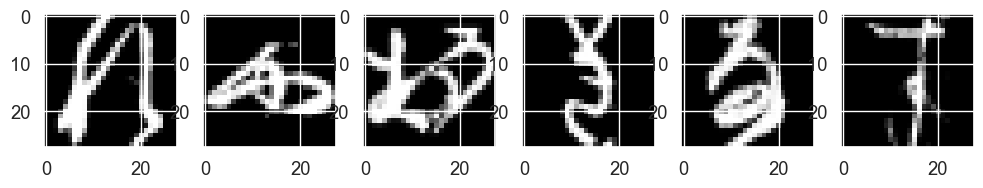

In [91]:
# showing images from KMNIST
num_imagens = 6
fig, axs = plt.subplots(1, num_imagens, figsize=(12, 4))
for i in range(num_imagens):
    axs[i].imshow(train_dataset[i][0].reshape(28, 28), cmap=plt.get_cmap("gray"))
plt.show()

In [92]:
# Now i'll try to decrease the batch_size to see the impact
batch_size = 60    # divide our 60.000 samples in 1000 batches x 60 batch_size

# defining the DataLoader
  ### we pass "True" to the shuffle parameter at the train loader to help the weights settle
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  ### shuffling the test loader won`t help our model, so we set to "False" 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input_dim = 784   # pixels 28 x 28 = 784 
output_dim = 10   # number of classes
n_iters = 9000   #iterations at each batch

# defining the epochs: in this case, 9000 / (60.000 / 100)
epochs = n_iters / (len(train_dataset) / batch_size)

lr_rate = 0.001  # learning rate

In [93]:
model = LogisticRegression(input_dim, output_dim)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [94]:
iter = 0
for epoch in range(int(epochs)):
             # getting the batches (from train_loader)
    for i, (images, labels) in enumerate(train_loader):
           # creating and resizing the image from the batch
        images = Variable(images.view(-1, 28 * 28))        # reshaping 1 vector of 784 dims
           # creating the labels also from batch
        labels = Variable(labels)                 # Variable: will be altered by gradient descent
           # must zero gradients for each epoch
        optimizer.zero_grad()
           # forward pass to compute each output
        outputs = model(images)
           # loss function: cross entropy
        loss = criterion(outputs, labels)
           # propagating the error by backward step
        loss.backward()
        optimizer.step()

        iter+=1
           # each time that iter has no remains when divided by 500, we get into this if
           ## and print the iteration time, loss and accuracy comparing to test_loader
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                        # .max() gets the class with highest probability (between 10)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.936172366142273. Accuracy: 37.310001373291016.
Iteration: 1000. Loss: 1.6783115863800049. Accuracy: 46.810001373291016.
Iteration: 1500. Loss: 1.514022946357727. Accuracy: 50.849998474121094.
Iteration: 2000. Loss: 1.3059967756271362. Accuracy: 52.220001220703125.
Iteration: 2500. Loss: 1.1746238470077515. Accuracy: 53.369998931884766.
Iteration: 3000. Loss: 1.2735579013824463. Accuracy: 53.939998626708984.
Iteration: 3500. Loss: 1.3359564542770386. Accuracy: 54.849998474121094.
Iteration: 4000. Loss: 1.156836748123169. Accuracy: 55.22999954223633.
Iteration: 4500. Loss: 0.9701583385467529. Accuracy: 55.84000015258789.
Iteration: 5000. Loss: 1.1835672855377197. Accuracy: 56.290000915527344.
Iteration: 5500. Loss: 0.9093285202980042. Accuracy: 56.810001373291016.
Iteration: 6000. Loss: 1.1372946500778198. Accuracy: 57.20000076293945.
Iteration: 6500. Loss: 0.8273910880088806. Accuracy: 57.61000061035156.
Iteration: 7000. Loss: 0.9333671927452087. Accuracy: 58.049

In [96]:
# Now i'll try to increase the batch_size to see the impact
batch_size = 120    # divide our 60.000 samples in 500 batches x 120 batch_size

In [97]:
iter = 0
for epoch in range(int(epochs)):
             # getting the batches (from train_loader)
    for i, (images, labels) in enumerate(train_loader):
           # creating and resizing the image from the batch
        images = Variable(images.view(-1, 28 * 28))        # reshaping 1 vector of 784 dims
           # creating the labels also from batch
        labels = Variable(labels)                 # Variable: will be altered by gradient descent
           # must zero gradients for each epoch
        optimizer.zero_grad()
           # forward pass to compute each output
        outputs = model(images)
           # loss function: cross entropy
        loss = criterion(outputs, labels)
           # propagating the error by backward step
        loss.backward()
        optimizer.step()

        iter+=1
           # each time that iter has no remains when divided by 500, we get into this if
           ## and print the iteration time, loss and accuracy comparing to test_loader
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                        # .max() gets the class with highest probability (between 10)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.9538614153862. Accuracy: 60.5.
Iteration: 1000. Loss: 0.8264051675796509. Accuracy: 60.61000061035156.
Iteration: 1500. Loss: 0.9305620193481445. Accuracy: 60.880001068115234.
Iteration: 2000. Loss: 0.8072429299354553. Accuracy: 61.15999984741211.
Iteration: 2500. Loss: 0.794979453086853. Accuracy: 61.470001220703125.
Iteration: 3000. Loss: 0.9219332337379456. Accuracy: 61.54999923706055.
Iteration: 3500. Loss: 0.8371849656105042. Accuracy: 61.79999923706055.
Iteration: 4000. Loss: 0.8313083648681641. Accuracy: 62.13999938964844.
Iteration: 4500. Loss: 0.881720781326294. Accuracy: 62.220001220703125.
Iteration: 5000. Loss: 0.7349386811256409. Accuracy: 62.43000030517578.
Iteration: 5500. Loss: 0.8584699630737305. Accuracy: 62.630001068115234.
Iteration: 6000. Loss: 0.667232871055603. Accuracy: 62.810001373291016.
Iteration: 6500. Loss: 0.7201656103134155. Accuracy: 62.939998626708984.
Iteration: 7000. Loss: 0.763719916343689. Accuracy: 63.130001068115234.
Iterat

In [99]:
# increase more the batch_size
batch_size = 200    # divide our 60.000 samples in 300 batches x 200 batch_size

In [100]:
iter = 0
for epoch in range(int(epochs)):
             # getting the batches (from train_loader)
    for i, (images, labels) in enumerate(train_loader):
           # creating and resizing the image from the batch
        images = Variable(images.view(-1, 28 * 28))        # reshaping 1 vector of 784 dims
           # creating the labels also from batch
        labels = Variable(labels)                 # Variable: will be altered by gradient descent
           # must zero gradients for each epoch
        optimizer.zero_grad()
           # forward pass to compute each output
        outputs = model(images)
           # loss function: cross entropy
        loss = criterion(outputs, labels)
           # propagating the error by backward step
        loss.backward()
        optimizer.step()

        iter+=1
           # each time that iter has no remains when divided by 500, we get into this if
           ## and print the iteration time, loss and accuracy comparing to test_loader
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                        # .max() gets the class with highest probability (between 10)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.632262110710144. Accuracy: 63.790000915527344.
Iteration: 1000. Loss: 0.5312327146530151. Accuracy: 63.91999816894531.
Iteration: 1500. Loss: 0.7567261457443237. Accuracy: 64.05999755859375.
Iteration: 2000. Loss: 0.8000458478927612. Accuracy: 64.16000366210938.
Iteration: 2500. Loss: 0.7069604992866516. Accuracy: 64.29000091552734.
Iteration: 3000. Loss: 0.7311757206916809. Accuracy: 64.3499984741211.
Iteration: 3500. Loss: 0.8351500034332275. Accuracy: 64.31999969482422.
Iteration: 4000. Loss: 1.0065314769744873. Accuracy: 64.48999786376953.
Iteration: 4500. Loss: 0.8240236043930054. Accuracy: 64.44999694824219.
Iteration: 5000. Loss: 0.6533071994781494. Accuracy: 64.5.
Iteration: 5500. Loss: 0.7375333309173584. Accuracy: 64.58999633789062.
Iteration: 6000. Loss: 0.9733923077583313. Accuracy: 64.62999725341797.
Iteration: 6500. Loss: 0.7253843545913696. Accuracy: 64.62999725341797.
Iteration: 7000. Loss: 0.8430479764938354. Accuracy: 64.80000305175781.
Iterati

# Increasing batch_size 
- increased the accuracy of the model

1) batch_size = 60
    -  after 9000 iterations: 
       - accuracy = 59.97%
       - loss = 0.878
2) batch_size = 120
    -  after 9000 iterations: 
       - accuracy = 63.73%
       - loss = 0.684
3) batch_size = 200
    - accuracy already started at 63% 
    - loss had variations, and ended almost like betch_size = 120
    -  after 9000 iterations: 
       - accuracy = 64.97%
       - loss = 0.693
       
## So, we should balance this two parameters to evaluate our model       
- I'll stay with batch_size = 200, because it leads to the highest accuracy

In [101]:
predicted_list = []
estimated_list = []

for images, labels in test_dataset:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    # class 'torch.Tensor'
    predicted_list.append(predicted.item())
    estimated_list.append(labels)
estimations = pd.DataFrame(data={'predicted':predicted_list, 'estimated':estimated_list})

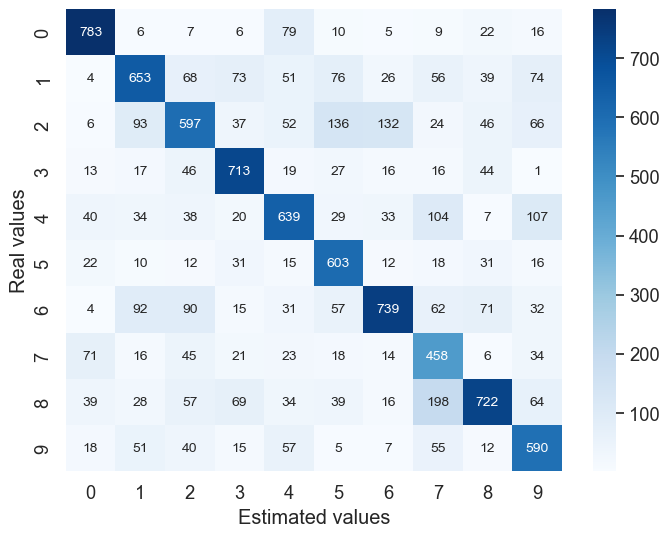

In [104]:
cm = confusion_matrix(predicted_list, estimated_list)

df_cm = pd.DataFrame(cm)
df_cm.index.name = "Real values"
df_cm.columns.name = "Estimated values"
plt.figure(figsize = (8,6))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()

- The numbers 7 and 8 are the ones that the model is most confused by
- but also 2 and 5/6 are leading to false positive evaluations

## Now, I'll try to horizontally flip some images using `transforms`
- Horizontally flip the given image randomly with a given probability: default is 50%

## Validation set
- Looking for **overfitting** (great performance in train and bad on test sets)
- To evaluate the model while trainning, we separate a validation set, this way, we can avoid overfitting


In [126]:
# creating trasnform pipeline
transformations = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(20), 
                                      transforms.ToTensor()])

# loading the KMNIST dataset passing the transforms pipeline
train_dataset = dsets.KMNIST(root='./data', train=True, transform=transformations, download=True)
test_dataset = dsets.KMNIST(root='./data', train=False, transform=transformations)

In [108]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [127]:
# Now I'll create a validation set from our training set
from torch.utils.data.sampler import SubsetRandomSampler

#Setting our validation size to 20% of our training set
validation_size = 0.2

# Get the size of our train set
training_size = len(train_dataset)

In [128]:
# then, we create a list of indices from 0 to training size range
indices = list(range(training_size))

# Shiffling the indices
np.random.shuffle(indices)

# The shuffled index will split the validation and training datasets using numpy "floor" method:
index_split = int(np.floor(training_size * validation_size))  # floor of the scalar `x` is the largest integer

# Then, we get the training and validation set indices passing the index split 
validation_indices, training_indices = indices[:index_split], indices[index_split:]

print(index_split)

12000


In [129]:
# Using SubsetRandomSampler we sample elements randomly from a list of indices
training_sample = SubsetRandomSampler(training_indices)
validation_sample = SubsetRandomSampler(validation_indices)

In [130]:
# checking the samples
len(training_sample), len(validation_sample)

(48000, 12000)

In [131]:
batch_size = 200   

# creating the data loader, passing the sampler created above
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sample)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=validation_sample)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

input_dim = 784   # pixels 28 x 28 = 784 
output_dim = 10   # number of classes
n_iters = 6000   #iterations at each batch

# defining the epochs: in this case, 9000 / (60.000 / 100)
epochs = n_iters / (len(train_dataset) / batch_size)

lr_rate = 0.001  # learning rate

In [132]:
model = LogisticRegression(input_dim, output_dim)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [134]:
for epoch in range(int(epochs)):
    train_loss = 0.0
    valid_loss = 0.0
    
    #model.train()
    for batch_size, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))     
        labels = Variable(labels)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        
    #model.eval()
    for batch_size, (images, labels) in enumerate(valid_loader):
        images = Variable(images.view(-1, 28 * 28))     
        labels = Variable(labels)
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} |')

| Epoch: 00 | Train Loss: 2.256 | Val. Loss: 2.184 |
| Epoch: 01 | Train Loss: 2.130 | Val. Loss: 2.079 |
| Epoch: 02 | Train Loss: 2.031 | Val. Loss: 1.993 |
| Epoch: 03 | Train Loss: 1.949 | Val. Loss: 1.920 |
| Epoch: 04 | Train Loss: 1.882 | Val. Loss: 1.858 |
| Epoch: 05 | Train Loss: 1.826 | Val. Loss: 1.806 |
| Epoch: 06 | Train Loss: 1.776 | Val. Loss: 1.761 |
| Epoch: 07 | Train Loss: 1.734 | Val. Loss: 1.722 |
| Epoch: 08 | Train Loss: 1.697 | Val. Loss: 1.687 |
| Epoch: 09 | Train Loss: 1.663 | Val. Loss: 1.655 |
| Epoch: 10 | Train Loss: 1.632 | Val. Loss: 1.628 |
| Epoch: 11 | Train Loss: 1.605 | Val. Loss: 1.606 |
| Epoch: 12 | Train Loss: 1.583 | Val. Loss: 1.584 |
| Epoch: 13 | Train Loss: 1.563 | Val. Loss: 1.563 |
| Epoch: 14 | Train Loss: 1.544 | Val. Loss: 1.546 |
| Epoch: 15 | Train Loss: 1.526 | Val. Loss: 1.527 |
| Epoch: 16 | Train Loss: 1.509 | Val. Loss: 1.512 |
| Epoch: 17 | Train Loss: 1.495 | Val. Loss: 1.498 |
| Epoch: 18 | Train Loss: 1.480 | Val. Loss: 1

In [136]:
predicted_list = []
estimated_list = []

for images, labels in test_dataset:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    # class 'torch.Tensor'
    predicted_list.append(predicted.item())
    estimated_list.append(labels)
estimations = pd.DataFrame(data={'predicted':predicted_list, 'estimated':estimated_list})

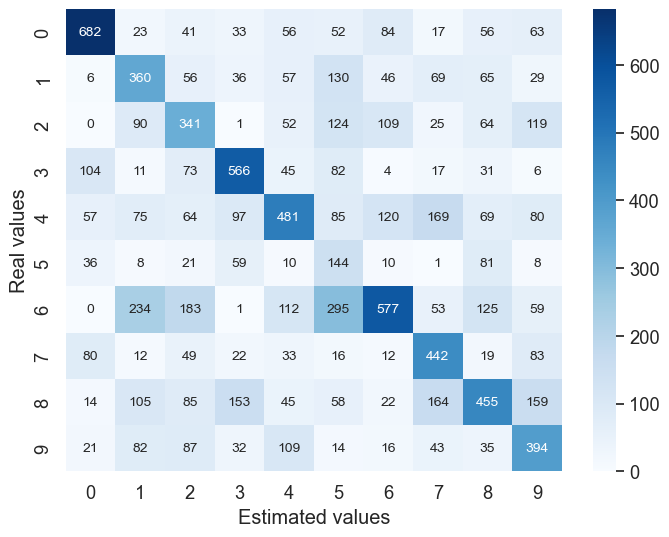

In [138]:
cm = confusion_matrix(predicted_list, estimated_list)

df_cm = pd.DataFrame(cm)
df_cm.index.name = "Real values"
df_cm.columns.name = "Estimated values"
plt.figure(figsize = (8,6))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()

In [139]:
## accuracy 
accuracy = (estimations['predicted'] == estimations['estimated']).sum()/len(estimations)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 44.42%


## The model now has a lower accuracy 
I passed the trasnform pipeline:

- RandomHorizontalFlip()
- RandomRotation(20)
- ToTensor()

Maybe this made the model more confuse, and it didn't helped in the training step.

# So, I created a function to the entire process of the model
- Now I can adjust the parameters and understand how they affect the model

In [ ]:
# loading the KMNIST dataset passing the transforms pipeline
train_dataset = dsets.KMNIST(root='./data', train=True, transform=transformations, download=True)
test_dataset = dsets.KMNIST(root='./data', train=False, transform=transformations)

In [146]:
def model_pipeline(train_dataset, test_dataset, horizontal_flip=False, flip_percentage=0.5,
                   random_rotation=False, rotation_degree=20, validation_size=0.2,
                   batch_size=200, output_dim=10, n_iters=6000, pixel=28, lr_rate=0.001):      

    # creating transform pipeline
    if horizontal_flip:
        transformations = transforms.Compose([transforms.RandomHorizontalFlip(flip_percentage)])
    if random_rotation:
        transformations = transforms.Compose([transforms.RandomRotation(rotation_degree)])
    
    transformations = transforms.Compose([transforms.ToTensor()])

    # Get the size of our train set
    training_size = len(train_dataset)

    # then, we create a list of indices from 0 to training size range
    indices = list(range(training_size))

    # Shuffling the indices
    np.random.shuffle(indices)

    # The shuffled index will split the validation and training datasets using numpy "floor" method:
    index_split = int(np.floor(training_size * validation_size))  # floor of the scalar `x` is the largest integer

    # Then, we get the training and validation set indices passing the index split 
    validation_indices, training_indices = indices[:index_split], indices[index_split:]

    # Using SubsetRandomSampler we sample elements randomly from a list of indices
    training_sample = SubsetRandomSampler(training_indices)
    validation_sample = SubsetRandomSampler(validation_indices)
   
    # creating the data loader, passing the sampler created above
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sample)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=validation_sample)
    test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

    # defining the epochs: in this case, 9000 / (60.000 / 100)
    epochs = n_iters / (len(train_dataset) / batch_size)
    
    # Calculating the input dimension 
    input_dim = pixel*pixel
    
    model = LogisticRegression(input_dim, output_dim)
    criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

    for epoch in range(1, int(epochs)+1):
        train_loss = 0.0
        valid_loss = 0.0

        #model.train()
        for batch_size, (images, labels) in enumerate(train_loader):
            images = Variable(images.view(-1,  pixel*pixel))     
            labels = Variable(labels)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.size(0)

        #model.eval()
        for batch_size, (images, labels) in enumerate(valid_loader):
            images = Variable(images.view(-1, pixel*pixel))     
            labels = Variable(labels)
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()*images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} |')

    predicted_list = []
    estimated_list = []

    for images, labels in test_dataset:
        images = Variable(images.view(-1, pixel*pixel))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted.item())
        estimated_list.append(labels)
    estimations = pd.DataFrame(data={'predicted':predicted_list, 'estimated':estimated_list})
    
    ## accuracy 
    accuracy = (estimations['predicted'] == estimations['estimated']).sum()/len(estimations)
    print(f'Accuracy comparing train and test: {accuracy*100:.2f}%')
    
    cm = confusion_matrix(predicted_list, estimated_list)

    df_cm = pd.DataFrame(cm)
    df_cm.index.name = "Real values"
    df_cm.columns.name = "Estimated values"
    plt.figure(figsize = (6,4))
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
    return plt.show()

## Passing only horizontal flip in 20% of the samples

| Epoch: 01 | Train Loss: 2.210 | Val. Loss: 2.115 |
| Epoch: 02 | Train Loss: 2.031 | Val. Loss: 1.965 |
| Epoch: 03 | Train Loss: 1.903 | Val. Loss: 1.859 |
| Epoch: 04 | Train Loss: 1.805 | Val. Loss: 1.774 |
| Epoch: 05 | Train Loss: 1.730 | Val. Loss: 1.706 |
| Epoch: 06 | Train Loss: 1.669 | Val. Loss: 1.655 |
| Epoch: 07 | Train Loss: 1.621 | Val. Loss: 1.609 |
| Epoch: 08 | Train Loss: 1.578 | Val. Loss: 1.570 |
| Epoch: 09 | Train Loss: 1.543 | Val. Loss: 1.541 |
| Epoch: 10 | Train Loss: 1.516 | Val. Loss: 1.512 |
| Epoch: 11 | Train Loss: 1.489 | Val. Loss: 1.488 |
| Epoch: 12 | Train Loss: 1.468 | Val. Loss: 1.469 |
Accuracy comparing train and test: 44.61%


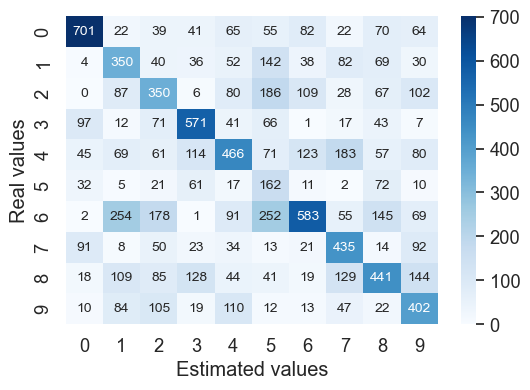

In [147]:
model_pipeline(train_dataset, test_dataset, horizontal_flip=True, flip_percentage=0.2, batch_size=120)

| Epoch: 01 | Train Loss: 2.227 | Val. Loss: 2.161 |
| Epoch: 02 | Train Loss: 2.111 | Val. Loss: 2.055 |
| Epoch: 03 | Train Loss: 2.020 | Val. Loss: 1.971 |
| Epoch: 04 | Train Loss: 1.942 | Val. Loss: 1.899 |
| Epoch: 05 | Train Loss: 1.877 | Val. Loss: 1.841 |
| Epoch: 06 | Train Loss: 1.821 | Val. Loss: 1.786 |
| Epoch: 07 | Train Loss: 1.773 | Val. Loss: 1.741 |
| Epoch: 08 | Train Loss: 1.734 | Val. Loss: 1.701 |
| Epoch: 09 | Train Loss: 1.696 | Val. Loss: 1.668 |
| Epoch: 10 | Train Loss: 1.664 | Val. Loss: 1.635 |
| Epoch: 11 | Train Loss: 1.636 | Val. Loss: 1.608 |
| Epoch: 12 | Train Loss: 1.609 | Val. Loss: 1.584 |
| Epoch: 13 | Train Loss: 1.588 | Val. Loss: 1.561 |
| Epoch: 14 | Train Loss: 1.566 | Val. Loss: 1.540 |
| Epoch: 15 | Train Loss: 1.547 | Val. Loss: 1.520 |
| Epoch: 16 | Train Loss: 1.529 | Val. Loss: 1.502 |
| Epoch: 17 | Train Loss: 1.512 | Val. Loss: 1.492 |
| Epoch: 18 | Train Loss: 1.497 | Val. Loss: 1.475 |
| Epoch: 19 | Train Loss: 1.484 | Val. Loss: 1

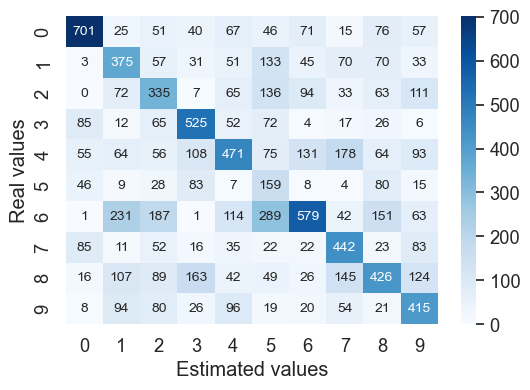

In [149]:
model_pipeline(train_dataset, test_dataset, random_rotation=True, rotation_degree=10, batch_size=200)